<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a two-photon Calcium Imaging dataset. The demo shows how to construct the `params`, `MotionCorrect` and `cnmf` objects and call the relevant functions. You can also run a large part of the pipeline with a single method (`cnmf.fit_file`). See inside for details.

Dataset couresy of Sue Ann Koay and David Tank (Princeton University)

This demo pertains to two photon data. For a complete analysis pipeline for one photon microendoscopic data see demo_pipeline_cnmfE.ipynb</span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in the companion paper. </span></p>
</html>



In [1]:

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile as tif

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

C:\Anaconda3\envs\py36\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


Loading BokehJS ...

In [3]:
images = tif.imread(r'C:/Users/bnste/Documents/scripts/jon_2p_data/JG24831_181210_field1_behavior_00001_00001.tif')[:400]
print(images.dtype)
print(images.shape)
tif.imsave(r'C:/Users/bnste/Documents/scripts/jon_2p_data/short_JG24831_181210_field1_behavior_00001_00001.tif',images.astype('float32'),imagej=True)

int16
(400, 512, 512)


### Set up logger (optional)
You can log to a file using the filename parameter, or make the output more or less verbose by setting level to `logging.DEBUG`, `logging.INFO`, `logging.WARNING`, or `logging.ERROR`. A filename argument can also be passed to store the log file

In [ ]:
#logging.basicConfig(format=
#                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
#                    # filename="/tmp/caiman.log",
#                    level=logging.WARNING)

### Select file(s) to be processed
The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fname` variable as a list.

In [4]:
#fnames = ['Sue_2x_3000_40_-46.tif']  # filename to be processed
fnames = ['C:/Users/bnste/Documents/scripts/jon_2p_data/short_JG24831_181210_field1_behavior_00001_00001.tif' , 'C:/Users/bnste/Documents/scripts/jon_2p_data/short_JG24831_181210_field1_behavior_00001_00002.tif']
if fnames[0] in ['Sue_2x_3000_40_-46.tif', 'demoMovie.tif']:
    fnames = [download_demo(fnames[0])]

### Play the movie (optional)
Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [ ]:
display_movie = True
if display_movie:
    m_orig = cm.load_movie_chain(fnames)
    ds_ratio = 0.2
    m_orig.resize(1, 1, ds_ratio).play(
        q_max=99.5, fr=8, magnification=2)

### Setup some parameters
We set some parameters that are relevant to the file, and then parameters for motion correction, processing with CNMF and component quality evaluation. Note that the dataset `Sue_2x_3000_40_-46.tif` has been spatially downsampled by a factor of 2 and has a lower than usual spatial resolution (2um/pixel). As a result several parameters (`gSig, strides, max_shifts, rf, stride_cnmf`) have lower values (halved compared to a dataset with spatial resolution 1um/pixel). 

In [45]:
# dataset dependent parameters
fr = 30                            # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True           # flag for performing non-rigid motion correction

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 4                     # number of global background components
merge_thresh = 0.8          # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [4, 4]               # expected half size of neurons in pixels
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 1.5               # signal to noise ratio for accepting a component
rval_thr = 0.85              # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected


### Create a parameters object
You can creating a parameters object by passing all the parameters as a single dictionary. Parameters not defined in the dictionary will assume their default values. The resulting `params` object is a collection of subdictionaries pertaining to the dataset to be analyzed `(params.data)`, motion correction `(params.motion)`, data pre-processing `(params.preprocess)`, initialization `(params.init)`, patch processing `(params.patch)`, spatial and temporal component `(params.spatial), (params.temporal)`, quality evaluation `(params.quality)` and online processing `(params.online)`

In [46]:
opts_dict = {'fnames': fnames,
            'fr': fr,
            'decay_time': decay_time,
            'strides': strides,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'max_deviation_rigid': max_deviation_rigid,
            'pw_rigid': pw_rigid,
            'border_nan': 'copy',
            'p': 1,
            'nb': gnb,
            'rf': rf,
            'K': K, 
            'stride': stride_cnmf,
            'method_init': method_init,
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'min_SNR': min_SNR,
            'rval_thr': rval_thr,
            'use_cnn': True,
            'min_cnn_thr': cnn_thr,
            'cnn_lowest': cnn_lowest}

opts = params.CNMFParams(params_dict=opts_dict)

C:\Anaconda3\envs\py36\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


### Setup a cluster
To enable parallel processing a (local) cluster needs to be set up. This is done with a cell below. The variable `backend` determines the type of cluster used. The default value `'local'` uses the multiprocessing package. The `ipyparallel` option is also available. More information on these choices can be found [here](https://github.com/flatironinstitute/CaImAn/blob/master/CLUSTER.md). The resulting variable `dview` expresses the cluster option. If you use `dview=dview` in the downstream analysis then parallel processing will be used. If you use `dview=None` then no parallel processing will be employed.

In [47]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

## Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [48]:
# first we create a motion correction object with the parameters specified
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
# note that the file is not loaded in memory

# import template
#mc_temp = None
mc_temp = tif.imread(r'C:\Users\bnste\Documents\scripts\jon_2p_data\Ref_for_movement_correction_2.tif')[0]

Now perform motion correction. From the movie above we see that the dateset exhibits non-uniform motion. We will perform piecewise rigid motion correction using the NoRMCorre algorithm. This has already been selected by setting `pw_rigid=True` when defining the parameters object.

In [52]:
m_els = cm.load(mc.fname_tot_els)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


In [50]:
%%capture
#%% Run piecewise-rigid motion correction using NoRMCorre
mc.motion_correct(save_movie=True, template=mc_temp)
m_rig = cm.load(mc.fname_rig)
border_to_0 = 0 if mc.border_nan is 'copy' else mc.border_to_0 
    # maximum shift to be used for trimming against NaNs

AttributeError: 'MotionCorrect' object has no attribute 'fname_tot_rig'

Inspect the results by comparing the original movie. A more detailed presentation of the motion correction method can be found in the [demo motion correction](./demo_motion_correction.ipynb) notebook.

In [ ]:
#%% compare with original movie
display_movie = False
if display_movie:
    m_orig = cm.load_movie_chain(fnames)
    ds_ratio = 0.5
    cm.concatenate([m_orig.resize(1, 1, ds_ratio) - mc.min_mov*mc.nonneg_movie,
                    m_rig.resize(1, 1, ds_ratio)], 
                   axis=2).play(fr=10, gain=4, magnification=2, offset=0)  # press q to exit

## Memory mapping 

The cell below memory maps the file in order `'C'` and then loads the new memory mapped file. The saved files from motion correction are memory mapped files stored in `'F'` order. Their paths are stored in `mc.mmap_file`.

In [53]:
#%% MEMORY MAPPING
# memory map the file in order 'C'
fname_new = cm.save_memmap(mc.fname_tot_els, base_name='memmap_', order='C',
                           border_to_0=border_to_0) # exclude borders

OSError: [Errno 22] Invalid argument: 'C:/Users/bnste/Documents/scripts/jon_2p_data\\memmap__d1_512_d2_512_d3_1_order_C_frames_800_.mmap'

In [54]:
1/(np.sum(images.shape)) * (np.sum(images[0,:,:] - m_els[0,:,:]) ) ** 2

258777638070092.34

(800, 262144)


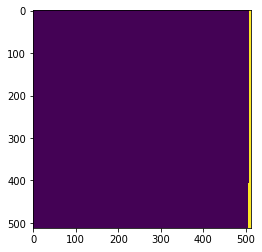

In [55]:
# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
print(Yr.T.shape)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)
plt.imshow(images.mean(axis=0)[:,:])

In [ ]:
writer = np.memmap(fname_new, order='C')
print(writer.shape)
images = np.reshape(writer.T, [T] + list(2*np.array(dims)), order='F')
print(images.shape)
images[:,:,(2*(-1)*mc.border_to_0):]=0
del writer, images

[95, 96, 97, 98, 99]

In [ ]:
test, dims, T = cm.load_memmap(mc.fname_tot_rig[0])
images = np.reshape(test, [T] + list(dims), order='F')
plt.subplot(1,2,1)
plt.imshow(m_rig.mean(axis=0))
plt.subplot(1,2,2)
plt.plot(m_rig.mean(axis=0)[:,255])

Now restart the cluster to clean up the memory

In [56]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

## Run CNMF on patches in parallel

<p> <img src="../../docs/img/cnmf1.png" /> </p>

- The FOV is split is different overlapping patches that are subsequently processed in parallel by the CNMF algorithm.
- The results from all the patches are merged with special attention to idendtified components on the border.
- The results are then refined by additional CNMF iterations.

In [ ]:
%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
opts.set('temporal', {'p': 0})
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit(images)

## Run the entire pipeline up to this point with one command
It is possible to run the combined steps of motion correction, memory mapping, and cnmf fitting in one step as shown below. The command is commented out since the analysis has already been performed. It is recommended that you familiriaze yourself with the various steps and the results of the various steps before using it.

In [ ]:
# cnm1 = cnmf.CNMF(n_processes, params=opts, dview=dview)
# cnm1.fit_file(motion_correct=True)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(cnm.estimates.b[:,0].reshape((256,256),order='F'))
plt.subplot(1,2,2)
plt.imshow(cnm.estimates.b[:,1].reshape((256,256),order='F'))

In [ ]:
plt.plot(cnm.estimates.f.transpose())

In [ ]:
plt.imshow(Yr.mean(axis=1).reshape((256,256),order='F')[:,:])

### Inspecting the results
Briefly inspect the results by plotting contours of identified components against correlation image.
The results of the algorithm are stored in the object `cnm.estimates`. More information can be found in the definition of the `estimates` object and in the [wiki](https://github.com/flatironinstitute/CaImAn/wiki/Interpreting-Results).

In [ ]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.plot_contours_nb(img=Cn)

## Re-run (seeded) CNMF  on the full Field of View  
You can re-run the CNMF algorithm seeded on just the selected components from the previous step. Be careful, because components rejected on the previous step will not be recovered here.

In [ ]:
%%capture
#%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
cnm.params.set('temporal', {'p': p})
cnm2 = cnm.refit(images, dview=dview)

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

cnm2.estimates.evaluate_components(images, cnm2.params, dview=dview)

Plot contours of selected and rejected components

In [ ]:
#%% PLOT COMPONENTS
cnm2.estimates.plot_contours_nb(img=Cn, idx=cnm2.estimates.idx_components)

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [ ]:
# accepted components
cnm2.estimates.nb_view_components(img=Cn, idx=cnm2.estimates.idx_components)

In [ ]:
# rejected components
if len(cnm2.estimates.idx_components_bad) > 0:
    cnm2.estimates.nb_view_components(img=Cn, idx=cnm2.estimates.idx_components_bad)
else:
    print("No components were rejected.")

### Extract DF/F values

In [ ]:
#%% Extract DF/F values
cnm2.estimates.detrend_df_f(quantileMin=8, frames_window=250)

### Select only high quality components

In [ ]:
cnm2.estimates.select_components(use_object=True)

## Display final results

In [ ]:
cnm2.estimates.nb_view_components(img=Cn, denoised_color='red')
print('you may need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 before opening jupyter notebook')

In [ ]:
nbgs=cnm2.estimates.b.shape[1]
plt.figure(figsize=(15,25))
for i in range(nbgs):
    plt.subplot(1,nbgs,i+1)
    plt.imshow(cnm2.estimates.b[:,i].reshape((256,256),order='F'))

## Closing, saving, and creating denoised version
### You can save an hdf5 file with all the fields of the cnmf object

In [ ]:
save_results = False
if save_results:
    cnm2.save('analysis_results.hdf5')


### Stop cluster and clean up LOG files

In [ ]:
#%% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

### View movie with the results
We can inspect the denoised results by reconstructing the movie and playing alongside the original data and the resulting (amplified) residual movie

In [ ]:
cnm2.estimates.play_movie(images, q_max=99.9, gain_res=2,
                                  magnification=2,
                                  bpx=border_to_0,
                                  include_bck=False)

The denoised movie can also be explicitly constructed using:

In [ ]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm2.estimates.A.dot(cnm2.estimates.C) + \
                    cnm2.estimates.b.dot(cnm2.estimates.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])